In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
laptops_df = pd.read_csv("../datasets/laptops_hw.csv")

In [5]:
laptops_df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [6]:
laptops_df.columns = laptops_df.columns.str.lower().str.replace(' ', '_')

In [7]:
column_to_normalize = list(laptops_df.dtypes[laptops_df.dtypes == "object"].index)

for col in column_to_normalize:
    laptops_df[col] = laptops_df[col].str.lower().str.replace(' ','_')

In [8]:
# Using only these specified columns for training
column_for_train = ["ram", "storage", "screen", "final_price"]

<Axes: xlabel='final_price', ylabel='Count'>

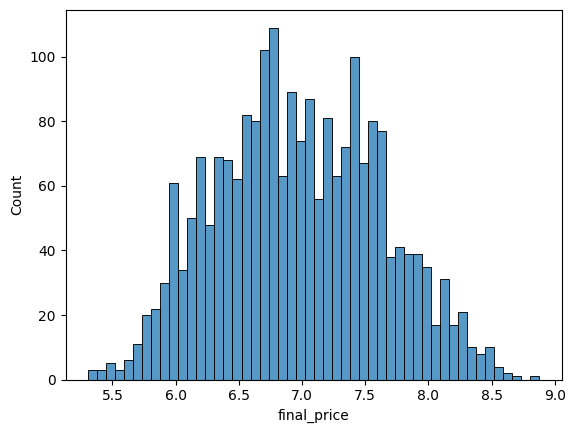

In [9]:
# Checking for long tail y values
sns.histplot(np.log1p(laptops_df.final_price), bins=50)

### Q1. Column with missing value

In [10]:
#Checking for missing values
for col in column_for_train:
    print(col)
    print(laptops_df[col].isna().sum())

ram
0
storage
0
screen
4
final_price
0


### Q2 RAM Median Value

In [11]:
laptops_df["ram"].median()

np.float64(16.0)

### TRAIN, VALIDATE, TEST SPLIT

In [12]:
n = len(laptops_df)
n_val = n_test = int(n * 0.2)
n_train = n - n_val - n_test

print(n_train, n_val, n_test)

1296 432 432


In [13]:
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

In [14]:
df_train = laptops_df.iloc[idx[:n_train]]
df_val = laptops_df.iloc[idx[n_train:n_train+n_val]]
df_test = laptops_df.iloc[idx[n_train+n_val:]]

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = np.log1p(df_train["final_price"].values)
y_val = np.log1p(df_val["final_price"].values)
y_test = np.log1p(df_test["final_price"].values)

In [17]:
del df_train["final_price"]
del df_val["final_price"]
del df_test["final_price"]

### MODEL

In [18]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
     
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
     
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
     
    XTX = X.T.dot(X)
    XTX = XTX + r*np.eye(XTX.shape[0])
     
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
     
    return w_full[0], w_full[1:]

### QUESTION 3

In [20]:
column_for_train = ["ram", "storage", "screen"]

In [21]:
# Dealing with missing values of screen column
df_train_zero = df_train[column_for_train].copy()
df_train_mean = df_train[column_for_train].copy()
df_train_zero["screen"] = df_train["screen"].fillna(0).values

mean_to_fill = df_train["screen"].mean()
df_train_mean["screen"] = df_train["screen"].fillna(mean_to_fill).values

In [22]:
w0_zero, w_zero = train_linear_regression(df_train_zero, y_train)
w0_mean, w_mean = train_linear_regression(df_train_mean, y_train)

print(w0_zero, w_zero)
print(w0_mean, w_mean)

6.7271637061124565 [ 0.02630589  0.00066041 -0.03651909]
6.855566544134476 [ 0.02650252  0.00066643 -0.04534341]


In [23]:
y_pred_zero = w0_zero + df_train_zero.dot(w_zero)

y_pred_mean = w0_mean + df_train_mean.dot(w_mean)


In [24]:
rmse(y_train, y_pred_zero)

np.float64(0.44632651855038796)

In [25]:
rmse(y_train, y_pred_mean)

np.float64(0.4460856669097624)

### QUESTION 4

In [26]:
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in r_list:
    w0, w = train_linear_regression_reg(df_train_zero, y_train, r)
    y_pred = w0 + df_train_zero.dot(w)

    print(f"Regularization index: {r}, yields error of {round(rmse(y_train, y_pred),2)}")

Regularization index: 0, yields error of 0.45
Regularization index: 0.01, yields error of 0.45
Regularization index: 0.1, yields error of 0.45
Regularization index: 1, yields error of 0.45
Regularization index: 5, yields error of 0.49
Regularization index: 10, yields error of 0.53
Regularization index: 100, yields error of 0.71


### QUESTION 5

In [29]:
column_for_train = ["ram", "storage", "screen", "final_price"]

In [30]:
def prepare_split(n, seed):
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)

    df_train = laptops_df[column_for_train].iloc[idx[:n_train]]
    df_val = laptops_df[column_for_train].iloc[idx[n_train:n_train+n_val]]
    df_test = laptops_df[column_for_train].iloc[idx[n_train+n_val:]]

    df_train["screen"] = df_train["screen"].fillna(0).values
    df_val["screen"] = df_val["screen"].fillna(0).values
    df_test["screen"] = df_test["screen"].fillna(0).values

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train["final_price"].values)
    y_val = np.log1p(df_val["final_price"].values)
    y_test = np.log1p(df_test["final_price"].values)

    del df_train["final_price"]
    del df_val["final_price"]
    del df_test["final_price"]

    return df_train, df_val, df_test, y_train, y_val, y_test

In [31]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_split(n, 42)

In [32]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rmse_scores = []

for seed in seed_values:
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_split(n, seed)

    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    rmse_scores.append(score)
    print(score)

0.43004215694158965
0.4520794495247242
0.4462625574236662
0.4464515565727131
0.4199805419364144
0.4254576323418724
0.4488322872387867
0.4309159875904646
0.4428849183283987
0.40840334262399886


In [33]:
round(np.std(rmse_scores),3)

np.float64(0.014)

### QUESTION 6

In [34]:
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)

df_train = laptops_df[column_for_train].iloc[idx[:n_train]]
df_val = laptops_df[column_for_train].iloc[idx[n_train:n_train+n_val]]
df_test = laptops_df[column_for_train].iloc[idx[n_train+n_val:]]

df_train["screen"] = df_train["screen"].fillna(0).values
df_val["screen"] = df_val["screen"].fillna(0).values
df_test["screen"] = df_test["screen"].fillna(0).values

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train["final_price"].values)
y_val = np.log1p(df_val["final_price"].values)
y_test = np.log1p(df_test["final_price"].values)

del df_train["final_price"]
del df_val["final_price"]
del df_test["final_price"]

In [35]:
df_full_train = pd.concat([df_train, df_val])
y_full_train = np.concatenate([y_train, y_val])

In [36]:
df_full_train = df_full_train.reset_index(drop=True)

In [37]:
w0, w = train_linear_regression_reg(df_full_train, y_full_train, 0.001)

y_pred = w0 + df_test.dot(w)

rmse(y_test, y_pred)

np.float64(0.4553047228090914)